In [11]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import mat73

import sys
sys.path.append("..")
from hsvit.dataset import BrainTumorDataset
from hsvit.model import ViTBackbone
from hsvit.utils import compute_classification_metrics
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/"
cvind_path = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/cvind.mat"

In [4]:
split_data = mat73.loadmat(cvind_path)
split_labels = split_data['cvind']
train_ids = np.where(np.array(split_labels) == 1)[0]

In [ ]:
test_ids = np.where(np.array(split_labels) == 3)[0]
dataset = BrainTumorDataset(root_dir)
test_loader = DataLoader(Subset(dataset, list(test_ids)), batch_size=4, shuffle=False)

In [7]:
model = ViTBackbone().to(device)
state_dict = torch.load("/Users/darshdave/Documents/BRAINTUMOR/HSViT/model-weight/hsvit_best.pt", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()

ViTBackbone(
  (pre_encoder): PreEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, e

In [8]:
classes = {0: 'Meningioma', 1: 'Pituitary', 2: 'Glioma'}

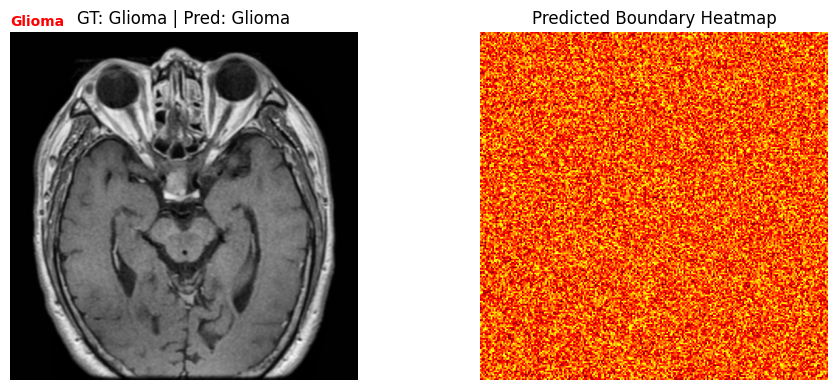

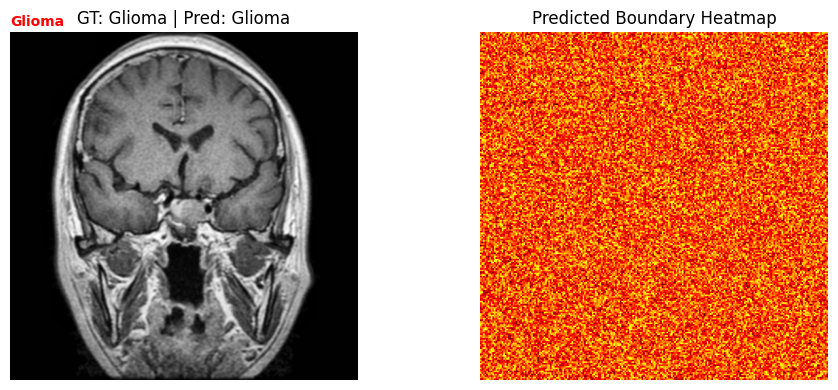

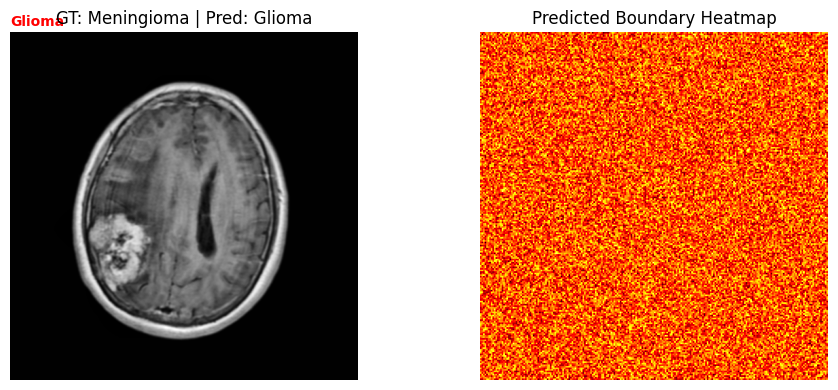

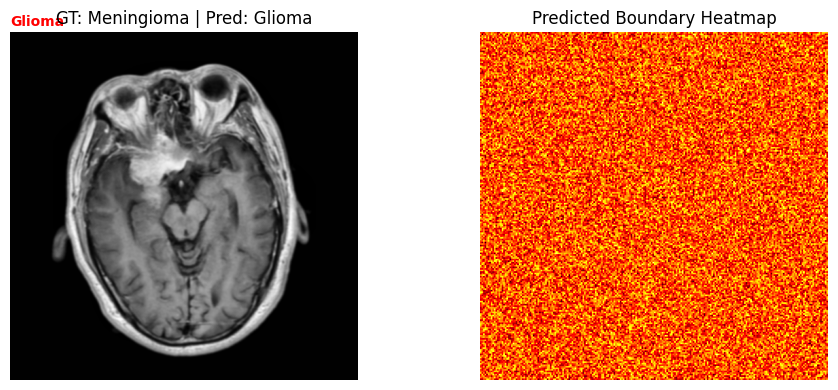

In [10]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device) - 1
        class_logits, bbox_preds, boundary_preds = model(images)

        preds = torch.argmax(class_logits, dim=1)

        for i in range(images.size(0)):
            img = images[i].squeeze().cpu().numpy()
            pred_class = preds[i].item()
            true_class = labels[i].item()
            bbox = bbox_preds[i].cpu().numpy()
            boundary = boundary_preds[i].squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))

            axs[0].imshow(img, cmap='gray')
            axs[0].set_title(f"GT: {classes[true_class]} | Pred: {classes[pred_class]}")
            axs[0].axis('off')

            axs[1].imshow(boundary, cmap='hot')
            axs[1].set_title("Predicted Boundary Heatmap")
            axs[1].axis('off')

            # Draw predicted bounding box on original image
            x, y, w, h = map(int, bbox)
            axs[0].add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
            axs[0].text(x, y-10, f"{classes[pred_class]}", color='red', fontsize=10, weight='bold')
            plt.tight_layout()
            plt.show()

        break